In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from pathlib import Path
from scipy import stats
from statannot import add_stat_annotation
import itertools

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}
matplotlib.rc('font', **font)

In [ ]:
#extract data and compute green/red ratio

directories = ["path/to/directory"] 
filters = ['csv/mask.csv',]
filters_names = ['new']

df = pd.DataFrame()
for j in range(len(directories)):
    os.chdir(directories[j])
    for i in range(len(filters)):
        cell = pd.read_csv(filters[i])
        cell.rename(columns={"AreaShape_Area":"Area",
                "Location_Center_X":"X_loc",
                "Location_Center_Y": "Y_loc",
                "AreaShape_Eccentricity":"Eccentricity",
                "AreaShape_Solidity":"Solidity",
                "Intensity_MeanIntensity_pERK": "Average Cell pERK",
                "Intensity_MeanIntensity_mRuby3": "Average Cell iTrkA",
                "Intensity_MedianIntensity_mRuby3": "Median Cell iTrkA",
                "Metadata_conc": "Concentration",
                "Metadata_change": "Light"}, inplace=True)

        cell = cell.reindex(columns=['Concentration', 'Light', 'Area','Eccentricity', 'Solidity', 'Average Cell pERK', 
                                'Average Cell iTrkA', 'ImageNumber', 
                                'ObjectNumber', "X_loc", "Y_loc"])

        cell["pERK to iTrkA ratio"] = cell['Average Cell pERK']/cell['Average Cell iTrkA']
        cell['cellpose_filter'] = filters_names[i]
        cell['experiment'] = str(j)
        df = pd.concat([df, cell])

df.shape[0]

6577
1316


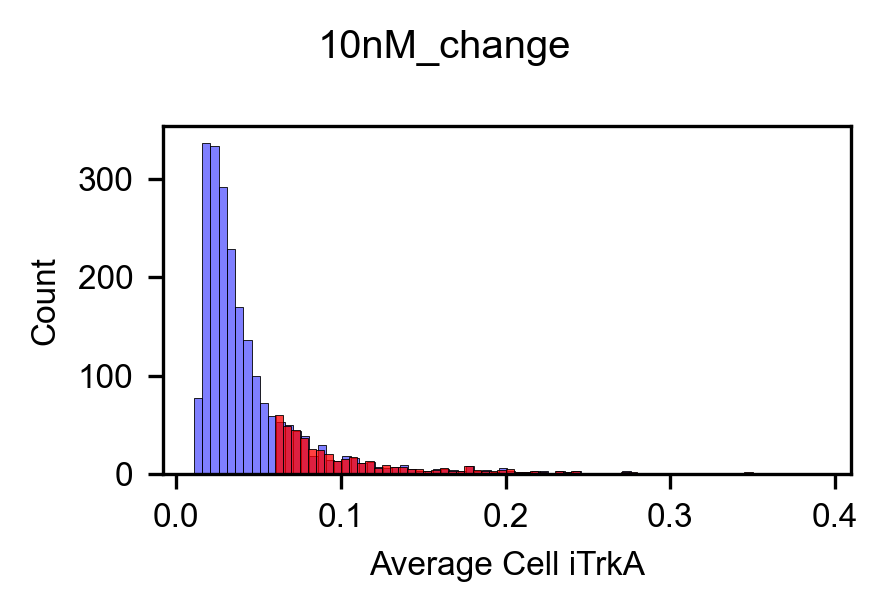

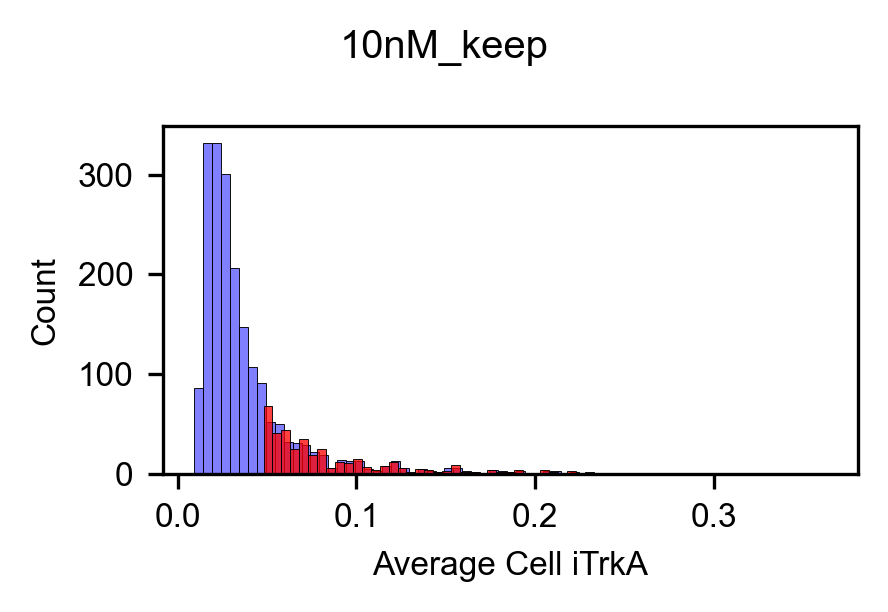

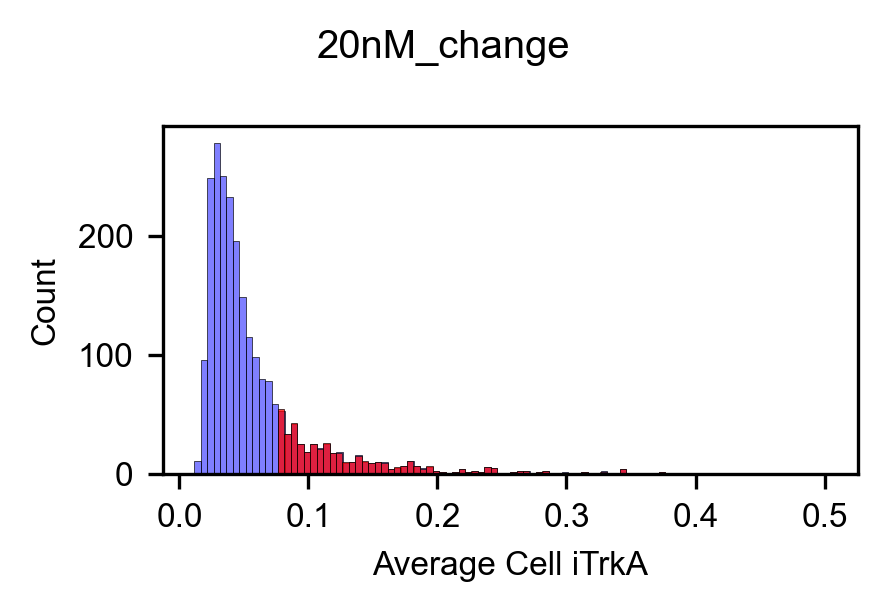

In [5]:
# plot histograms of the intensity of segmented cells; keep top 20%

slides = ['10nM_change', '10nM_keep', '20nM_change']
df_sel = df.copy()
df_filter = pd.DataFrame()
for s in slides:
    df_temp = df_sel[df_sel['Concentration'] == s]
    fig, ax = plt.subplots(ncols = 1, figsize=(3,2), dpi=300)
    sns.histplot(data=df_temp, x='Average Cell iTrkA', color='b', alpha=0.5, ax=ax, binwidth=0.005)
        
    cutoff = np.percentile(df_temp['Average Cell iTrkA'], 80)
    df_temp = df_temp[df_temp['Average Cell iTrkA'] > cutoff]
    sns.histplot(data=df_temp, x='Average Cell iTrkA', color='r', ax=ax, binwidth=0.005)
    #sns.scatterplot(data=df_temp, x='Average Cell iTrkA', y='Average Cell pERK', hue='Light', hue_order=['light', 'dark'], ax=ax[1])
    #print("light", np.corrcoef(df_temp[df_temp['Light'] == 'light']['Average Cell iTrkA'], df_temp[df_temp['Light'] == 'light']['Average Cell pERK'])[0,1])
    #print("dark", np.corrcoef(df_temp[df_temp['Light'] == 'dark']['Average Cell iTrkA'], df_temp[df_temp['Light'] == 'dark']['Average Cell pERK'])[0,1])
    df_filter = pd.concat([df_filter, df_temp])
    fig.suptitle(s)
    plt.tight_layout()
print(df_sel['Average Cell iTrkA'].size)
print(df_filter['Average Cell iTrkA'].size)



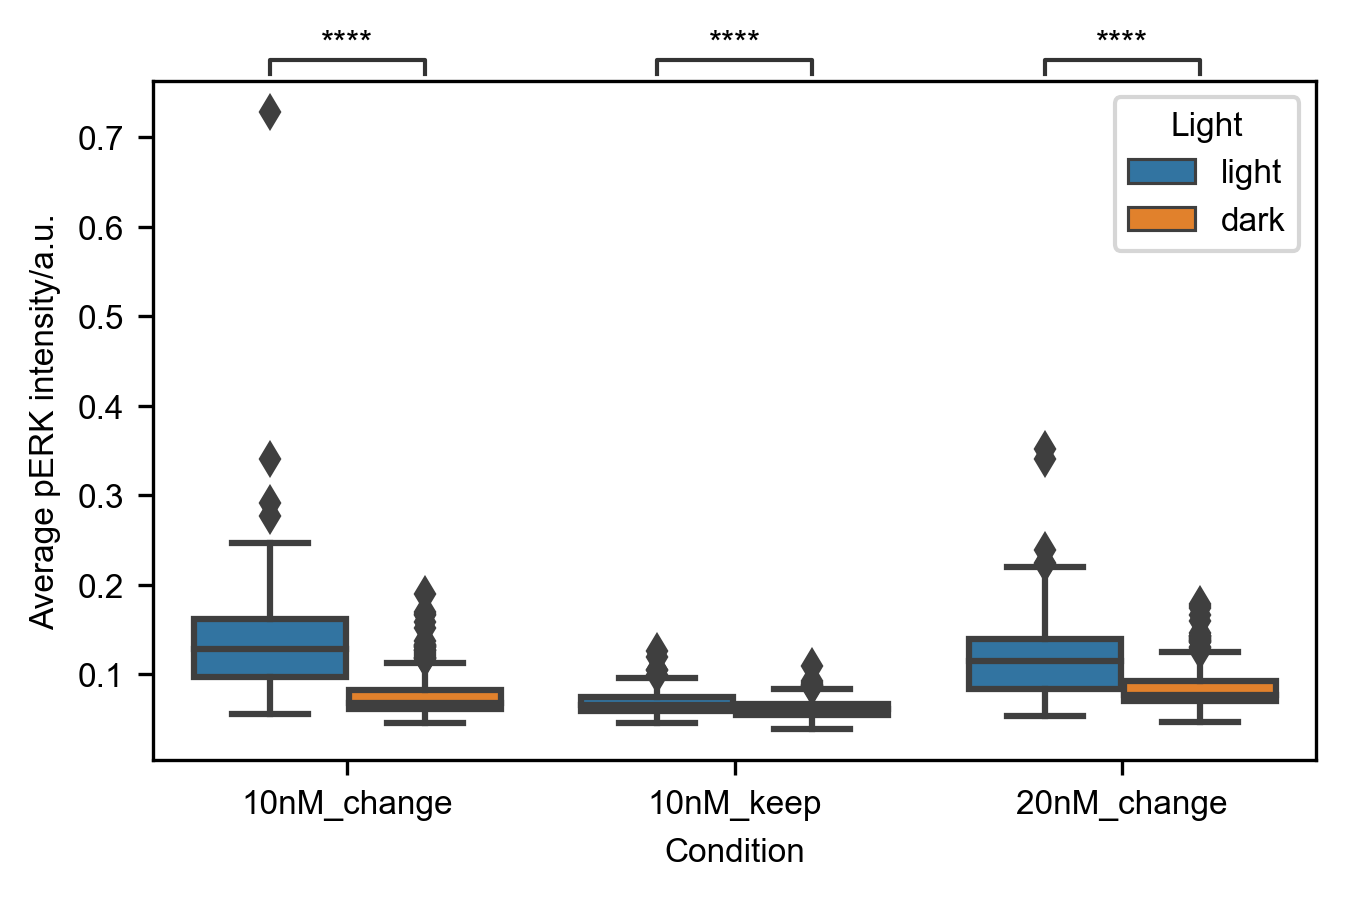

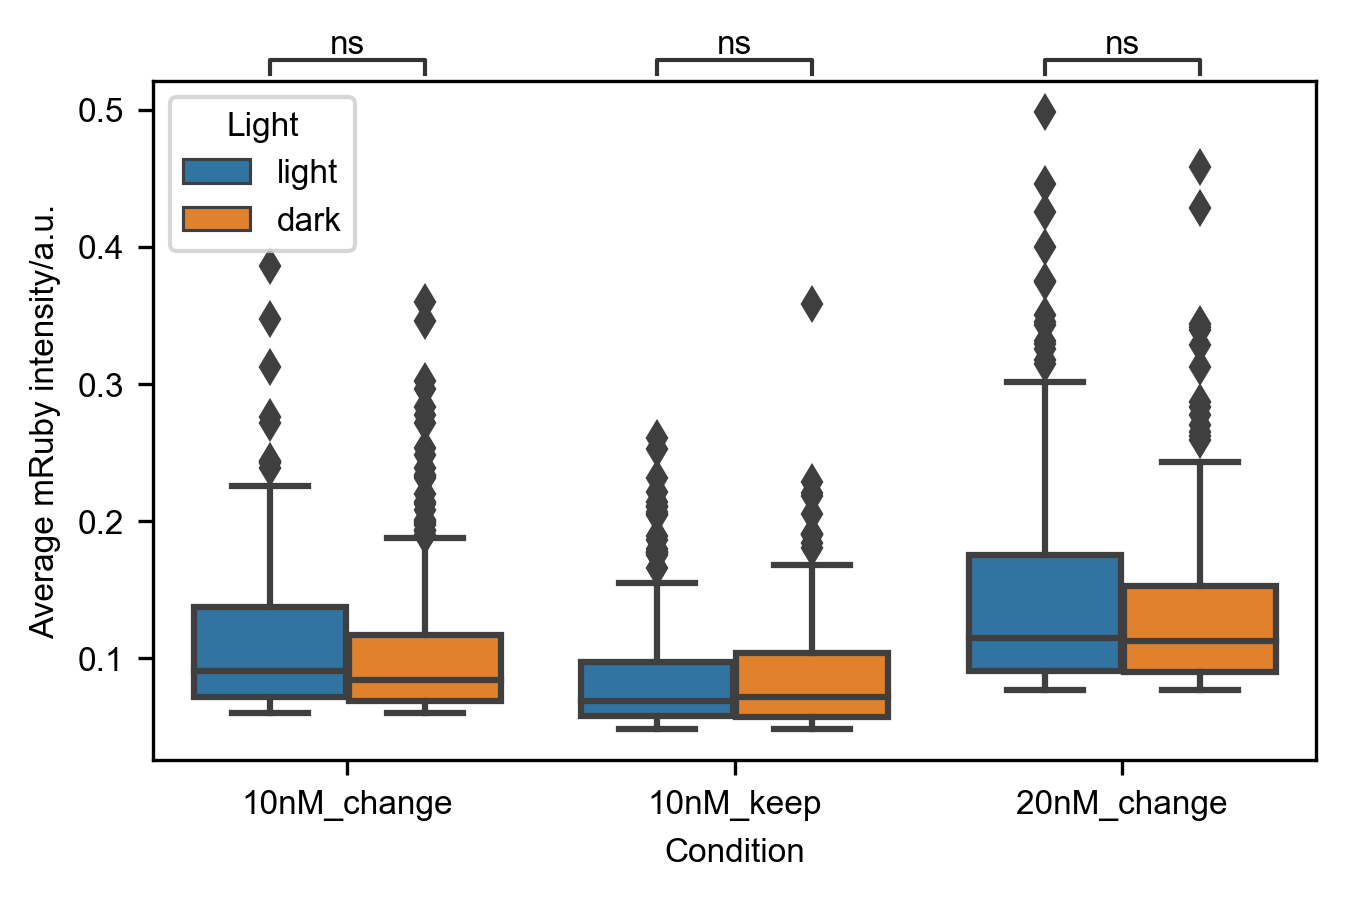

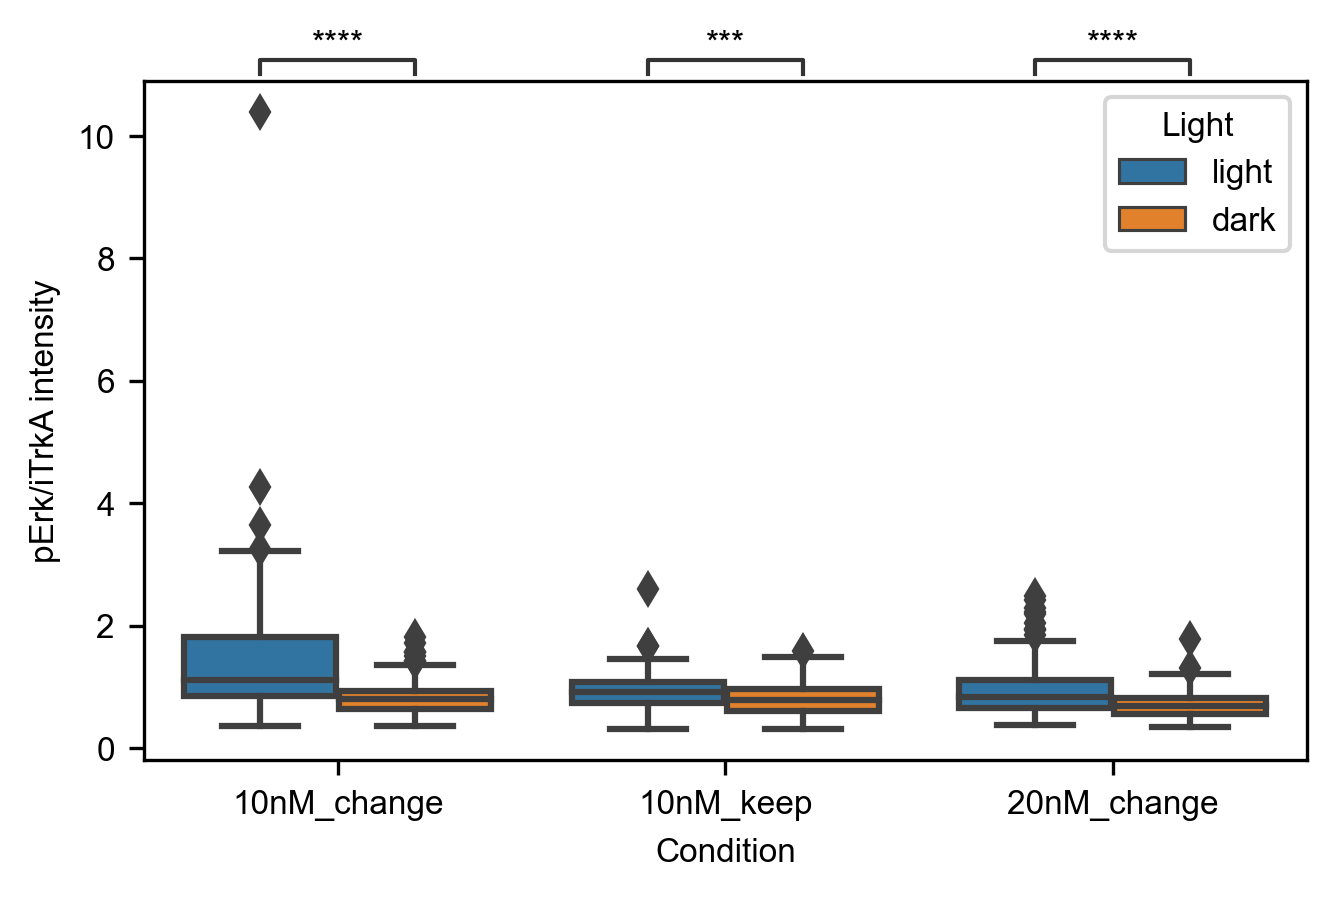

In [10]:
# plot pERK/iTrkA intensity

df_plot = df_filter.copy()
toplot = ['Average Cell pERK', 'Average Cell iTrkA', 'pERK to iTrkA ratio']
ylabel=['Average pERK intensity/a.u.', 'Average mRuby intensity/a.u.', 'pErk/iTrkA intensity']
order = ['10nM_change', '10nM_keep', '20nM_change']

box_pairs = [(("10nM_change","light"),("10nM_change","dark")),
             (("10nM_keep","light"), ("10nM_keep", "dark")),
             (("20nM_change","light"), ("20nM_change", "dark"))]


for i in range(len(toplot)):
    y_data = toplot[i]
    y_label=ylabel[i]
    fig, ax = plt.subplots(figsize=(5,3), dpi=300)
    sns.boxplot(data = df_plot, x = 'Concentration', y=y_data, ax=ax, hue='Light', order = order, hue_order = ['light', 'dark'])
    ax.set_ylabel(y_label)
    ax.set_xlabel("Condition")
    
    test = add_stat_annotation(ax, data=df_plot, x='Concentration', y=y_data, hue='Light',
                                       box_pairs=box_pairs, test='Mann-Whitney', text_format='star',
                                       line_height=0.02, text_offset=0.01, line_offset=0.01, line_offset_to_box=0.02,
                                       loc='outside', linewidth=1, verbose=0, comparisons_correction=None)


